In [5]:
## Figure 21. 2D histogram of average spatial coherence and temporal coherence all pixels on land from Sentinel-1 dataset

import os
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib import colors, pyplot as plt, ticker
from pysar.objects import sensor, timeseries, ifgramStack
from pysar.utils import readfile, plot as pp, utils as ut, ptime
from pysar.simulation.plot import *
from pysar import view

work_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
os.chdir(work_dir)
proj_name = sensor.project_name2sensor_name(work_dir)[1]

# spatialCoh vs tempCoh
spatial_coh_file = 'avgSpatialCoherence.h5'
temp_coh_file = 'temporalCoherence.h5'
temp_coh_file = 'UNW_COR/tempCoh_unwrapPhase.h5'
water_mask_file = 'waterMask.h5'

# lava flow
ts_file = 'GEOCODE/geo_timeseries_ECMWF_ramp_demErr.h5'
vel_file = 'GEOCODE/geo_velocity.h5'
dem_file = '../DEM/demLat_S02_N01_Lon_W092_W090.dem.wgs84'
ifgram_file = 'INPUTS/ifgramStack.h5'
geom_file = 'INPUTS/geometryRadar.h5'

lat, lon = 0.0232, -91.2838
ref_lat, ref_lon = 0.0243, -91.2891


print('Done.')

Done.


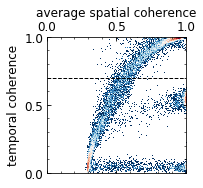

In [3]:
# read data
spatial_coh = readfile.read(spatial_coh_file)[0].flatten()
temp_coh = readfile.read(temp_coh_file)[0].flatten()
water_mask = readfile.read(water_mask_file)[0].flatten()

maskz = spatial_coh > 0.
maskz *= temp_coh > 0.
maskz = water_mask!=0   #pixels on land

# plot
fig, ax = plt.subplots(figsize=[2.5, 2.5])
#im = plt.hist2d(spatial_coh[maskz], temp_coh[maskz], bins=1000, norm=colors.LogNorm(), cmin=0, vmax=1e2, cmap='RdBu_r')
plt.hist2d(spatial_coh[maskz], temp_coh[maskz], bins=1000, norm=colors.LogNorm(), cmin=0, vmax=1e2, cmap='RdBu_r')

#temporal coherence threshold
ax.plot([0, 1], [0.7, 0.7], 'k--', lw=1.)
#colorbar
#cbar = plt.colorbar()
#cbar.set_label('# of Pixels', fontsize=font_size)


#format
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.tick_params(which='both', direction='in', top=True, bottom=True, left=True, right=True, labelsize=font_size)
ax.set_xlabel('average spatial coherence', fontsize=font_size)
ax.set_ylabel('temporal coherence', fontsize=font_size)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

plt.savefig('{}_coh_hist2d.png'.format(proj_name), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [6]:
def read_dis_timeseries_lalo(lat, lon, ts_file):
    obj = timeseries(ts_file)
    obj.open(print_msg=False)
    dates = ptime.date_list2vector(obj.dateList)[0]
    coord = ut.coordinate(obj.metadata)
    y, x = coord.geo2radar(lat, lon)[0:2]
    box = (x, y, x+1, y+1)
    ref_y, ref_x = coord.geo2radar(ref_lat, ref_lon)[0:2]
    ref_box = (ref_x, ref_y, ref_x+1, ref_y+1)
    dis = readfile.read(ts_file, box=box)[0] * 100.
    dis -= readfile.read(ts_file, box=ref_box)[0] * 100.
    dis -= dis[0]
    return dates, dis

save to file: GEOCODE/Wolf_lava_vel.png


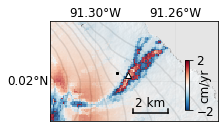

In [33]:
## Fig 2 - time-series on Wolf's lava flow
print_msg = False

fig, ax = plt.subplots(figsize=(3, 2))
## plot velocity
cmd  = 'view.py {} velocity -d {} '.format(vel_file, dem_file)
cmd += '--sub-lat 0.0 0.05 --sub-lon -91.323 -91.239 --wrap --wrap-range -2 2 --ref-lalo {} {} '.format(ref_lat, ref_lon)
cmd += '--notitle --notick --nocbar --ref-size 2 --fontsize 12 -c RdBu_r '
cmd += '--lalo-label --lalo-step 0.04 --lalo-loc 1 0 1 0 --scalebar 0.2 0.6 0.08 --scalebar-pad 0.1 '
d_v, atr, inps = view.prep_slice(cmd, print_msg=print_msg)
ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps, print_msg=print_msg)
# plot POI
ax.plot(lon, lat, '^', ms=6, mec='k', mfc='w', mew=1.)
# plot colorbar
#cax = fig.add_axes([0.3, 0.05, 0.4, 0.025])
cax = fig.add_axes([0.75, 0.23, 0.02, 0.35])
cbar = plt.colorbar(im, cax=cax, ticks=[-2, 2])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('cm/yr', fontsize=font_size, labelpad=-16)

#save
out_file = 'GEOCODE/Wolf_lava_vel.png'
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save to file: '+out_file)
plt.show()

save to file: GEOCODE/Wolf_lava_ts.png


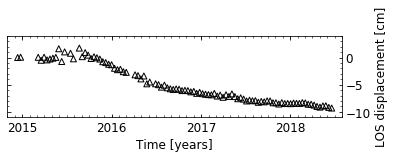

In [12]:
# read data
dates, dis = read_dis_timeseries_lalo(lat, lon, ts_file)

# plot
fig, ax = plt.subplots(figsize=[6, 1.5])
ax.scatter(dates, dis, marker='^', s=6**2, facecolors='none', edgecolors='k', linewidth=1.)

# axis format
pp.auto_adjust_xaxis_date(ax, dates[2:-1], fontsize=font_size)
ax.set_xlabel('Time [years]', fontsize=font_size)
ax.set_ylabel('LOS displacement [cm]', fontsize=font_size)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_ylim([-11, 4])
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

# save
out_file = 'GEOCODE/Wolf_lava_ts.png'
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save to file: '+out_file)
plt.show()

save to file: GEOCODE/Wolf_lava_cohMat.png


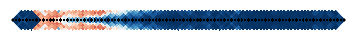

In [46]:
# read data
obj = ifgramStack(ifgram_file)
obj.open(print_msg=False)
coord = ut.coordinate(obj.metadata, geom_file)
y, x = coord.geo2radar(lat, lon)[0:2]
box = (x, y, x+1, y+1)
coh = np.squeeze(readfile.read(ifgram_file, datasetName='coherence', box=box, print_msg=False)[0])

# plot
fig, ax = plt.subplots(figsize=[6, 1])
ax, im = pp.plot_rotate_diag_coherence_matrix(ax, coh.tolist(), obj.date12List, cmap='RdBu', disp_min=0.0)
# save
out_file = 'GEOCODE/Wolf_lava_cohMat.png'
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save to file: '+out_file)
plt.show()

save to file: GEOCODE/Wolf_lava_cohMat_cbar.png


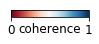

In [43]:
fig = plt.figure(figsize=(1.2, 0.1))
ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
cbar = mpl.colorbar.ColorbarBase(ax, cmap='RdBu', orientation='horizontal', ticks=[0, 1], extend='neither')
cbar.ax.set_xticklabels(['0', '1'])
cbar.ax.tick_params(which='both', direction='out', labelsize=font_size)
cbar.set_label('coherence', fontsize=font_size, labelpad=-14)
out_file = 'GEOCODE/Wolf_lava_cohMat_cbar.png'
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save to file: '+out_file)
plt.show()

In [19]:
np.sqrt(80**2 + 25**2) / 410 * 3000

613.2824858868369